<a href="https://colab.research.google.com/github/Vasyl808/deepfake_video_detection/blob/main/deepfake_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/archive.zip

Показано результат, скорочений до останніх рядків (5000).
  inflating: 1000_videos/train/real/id13_0002_2.png  
  inflating: 1000_videos/train/real/id13_0002_3.png  
  inflating: 1000_videos/train/real/id13_0002_4.png  
  inflating: 1000_videos/train/real/id13_0002_5.png  
  inflating: 1000_videos/train/real/id13_0002_6.png  
  inflating: 1000_videos/train/real/id13_0002_7.png  
  inflating: 1000_videos/train/real/id13_0002_8.png  
  inflating: 1000_videos/train/real/id13_0002_9.png  
  inflating: 1000_videos/train/real/id13_0003_0.png  
  inflating: 1000_videos/train/real/id13_0003_1.png  
  inflating: 1000_videos/train/real/id13_0003_10.png  
  inflating: 1000_videos/train/real/id13_0003_2.png  
  inflating: 1000_videos/train/real/id13_0003_3.png  
  inflating: 1000_videos/train/real/id13_0003_4.png  
  inflating: 1000_videos/train/real/id13_0003_5.png  
  inflating: 1000_videos/train/real/id13_0003_6.png  
  inflating: 1000_videos/train/real/id13_0003_7.png  
  inflating: 1000_video

In [3]:
import os
import cv2
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.applications import *
from keras.layers import *
from keras.models import Model, load_model
from keras.optimizers import Adam
from sklearn.utils import class_weight
from tqdm import tqdm
from keras.applications.xception import preprocess_input as base_preprocess
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, RocCurveDisplay, auc
from sklearn.utils.multiclass import unique_labels
from collections import Counter
from pathlib import Path
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

In [4]:
def load_data(data_dir: str, input_shape=(128, 128, 3)):
    X = []
    Y = []

    for label, sub_dir in enumerate(['real', 'fake']):
        images = [f for f in os.listdir(os.path.join(data_dir, sub_dir)) if f.endswith('.png')]
        for img in images:
            img_array = img_to_array(load_img(os.path.join(data_dir, sub_dir, img))).flatten() / 255.0
            X.append(img_array)
            Y.append(label)

    X = np.array(X).reshape(-1, *input_shape)
    Y = to_categorical(Y, 2)

    return X, Y

In [5]:
train_dir = '/content/1000_videos/train'
X_train, Y_train = load_data(train_dir)

val_dir = '/content/1000_videos/validation'
X_val, Y_val = load_data(val_dir)

test_dir = '/content/1000_videos/test'
X_test, Y_test = load_data(test_dir)

In [7]:
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_val shape:", X_val.shape)
print("Y_val shape:", Y_val.shape)

print("X_train contains None:", np.any(X_train == None))
print("Y_train contains None:", np.any(Y_train == None))
print("X_val contains None:", np.any(X_val == None))
print("Y_val contains None:", np.any(Y_val == None))


X_train shape: (11633, 128, 128, 3)
Y_train shape: (11633, 2)
X_val shape: (2400, 128, 128, 3)
Y_val shape: (2400, 2)
X_train contains None: False
Y_train contains None: False
X_val contains None: False
Y_val contains None: False


In [8]:
Y_train

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [ ]:
lr_reduce = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.5, patience = 5,mode='max', min_lr = 1e-4,verbose = 1)
early_stop = EarlyStopping(monitor = "val_loss", patience = 5, verbose=1)
saved_model = ('/content/Xception_model.keras')
model_chkpt = ModelCheckpoint(saved_model ,save_best_only = False, monitor = 'val_accuracy',verbose = 1)

callback_list = [early_stop, model_chkpt, lr_reduce]

In [ ]:
input_shape=(128, 128, 3)


base_model = Xception(weights='imagenet',
                      include_top=False,
                      input_shape=input_shape)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [19]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 63, 63, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 63, 63, 32)     │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 63, 63, 32)     │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 61, 61, 64)     │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 61, 61, 64)     │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 61, 61, 64)     │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 61, 61, 128)    │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 61, 61, 128)    │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 61, 61, 128)    │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 61, 61, 128)    │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 61, 61, 128)    │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 31, 31, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 31, 31, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 21,124,012 (80.58 MB)

 Trainable params: 21,069,482 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

 Optimizer params: 2 (12.00 B)

In [ ]:
epochs = 10
batch_size = 32

history = model.fit(X_train, Y_train, batch_size=batch_size,
                    validation_data=(X_val, Y_val),
                    epochs=epochs,
                    callbacks=callback_list)

Epoch 1/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.8365 - loss: 0.3608
Epoch 1: saving model to /content/Xception_model.keras
364/364 ━━━━━━━━━━━━━━━━━━━━ 172s 287ms/step - accuracy: 0.8367 - loss: 0.3605 - val_accuracy: 0.9154 - val_loss: 0.3965 - learning_rate: 0.0010
Epoch 2/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9574 - loss: 0.1230
Epoch 2: saving model to /content/Xception_model.keras
364/364 ━━━━━━━━━━━━━━━━━━━━ 75s 201ms/step - accuracy: 0.9574 - loss: 0.1229 - val_accuracy: 0.8904 - val_loss: 0.6195 - learning_rate: 0.0010
Epoch 3/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9779 - loss: 0.0570
Epoch 3: saving model to /content/Xception_model.keras
364/364 ━━━━━━━━━━━━━━━━━━━━ 87s 216ms/step - accuracy: 0.9779 - loss: 0.0570 - val_accuracy: 0.9029 - val_loss: 0.3906 - learning_rate: 0.0010
Epoch 4/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9830 - loss: 0.0392
Epoch 4: saving model to /content/Xception_model.k

In [7]:
from tensorflow.keras.models import load_model


model = load_model('/content/drive/MyDrive/deepfake-detection-model.h5')

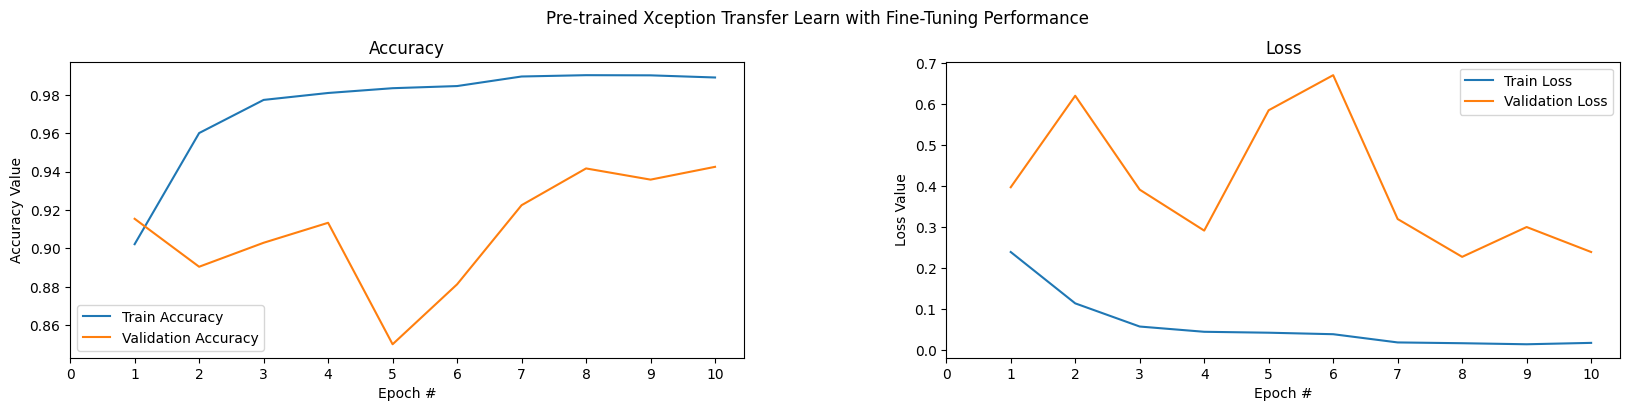

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
t = f.suptitle('Pre-trained Xception Transfer Learn with Fine-Tuning Performance ', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs+1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs+1, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs+1, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [12]:
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print("Test Accuracy:", test_accuracy)

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.9529 - loss: 0.2626
Test Accuracy: 0.9375


In [13]:
predictions = model.predict(X_test)

predicted_labels = np.argmax(predictions, axis=1)

true_labels = np.argmax(Y_test, axis=1)

report = classification_report(true_labels, predicted_labels)

print("Classification Report:")
print(report)

75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1200
           1       0.95      0.92      0.94      1200

    accuracy                           0.94      2400
   macro avg       0.94      0.94      0.94      2400
weighted avg       0.94      0.94      0.94      2400



Confusion matrix, without normalization


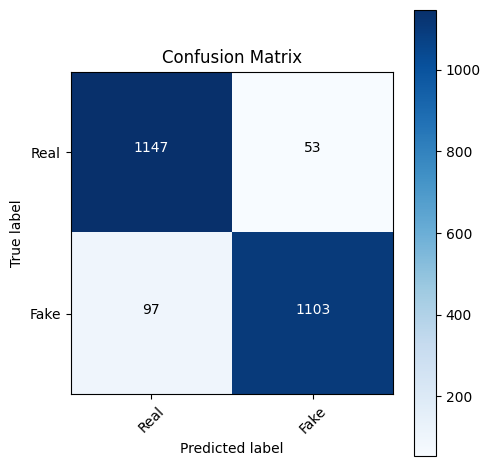

In [14]:
import itertools


def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    print('Confusion matrix, without normalization')

    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


cm_plot_labels = ["Real", "Fake"]

plot_confusion_matrix(confusion_matrix(true_labels, np.round(predicted_labels)), cm_plot_labels, title='Confusion Matrix')
plt.show()

In [10]:
from sklearn.metrics import roc_auc_score, roc_curve


predicted_probabilities = model.predict(X_test)[:, 1]  # Позитивний клас - фейк
roc_auc = roc_auc_score(Y_test[:, 1], predicted_probabilities)
print(f'ROC AUC Score: {roc_auc:.4f}')

75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step
ROC AUC Score: 0.9748


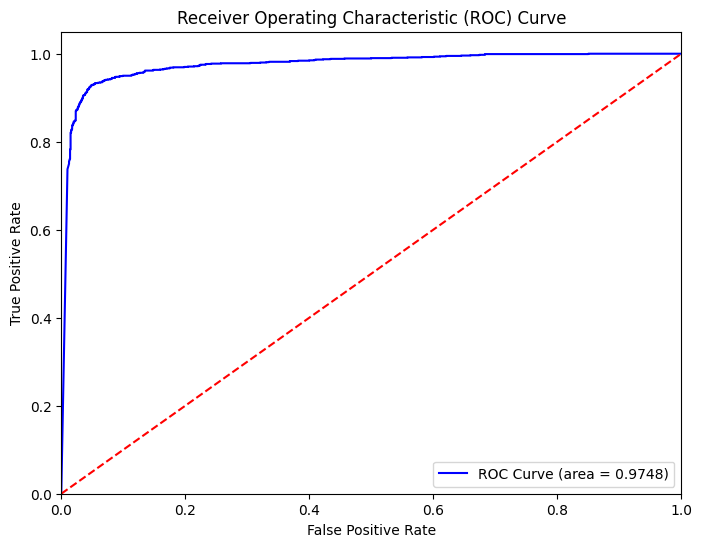

In [ ]:
fpr, tpr, thresholds = roc_curve(Y_test[:, 1], predicted_probabilities)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from sklearn.metrics import average_precision_score


predicted_probabilities = model.predict(X_test)[:, 1]  # Позитивний клас - фейк

ap_score = average_precision_score(Y_test[:, 1], predicted_probabilities)
print(f'Average Precision Score: {ap_score:.4f}')

75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step
Average Precision Score: 0.9724


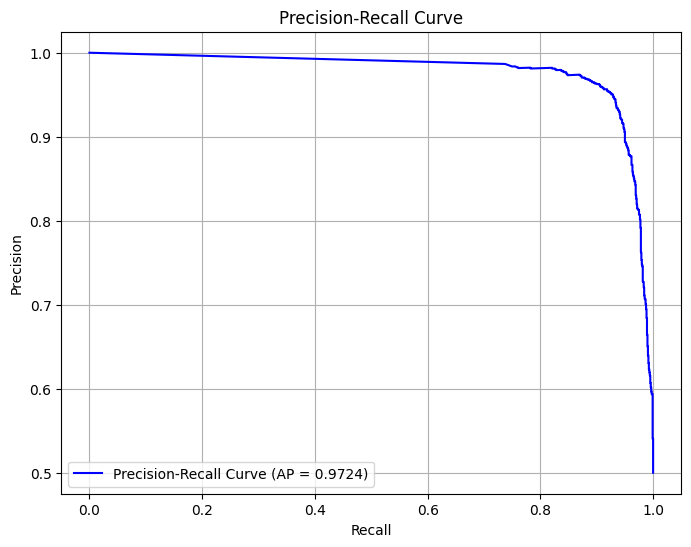

In [ ]:
from sklearn.metrics import precision_recall_curve


precision, recall, _ = precision_recall_curve(Y_test[:, 1], predicted_probabilities)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label=f'Precision-Recall Curve (AP = {ap_score:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()

In [ ]:
model.save('deepfake-detection-model.keras')

In [75]:
import cv2
import numpy as np


def extract_frames_from_video(video_path, frame_rate=10):
    cap = cv2.VideoCapture(video_path)
    frames = []
    success, frame = cap.read()
    count = 0

    while success:
        if count % frame_rate == 0:
            frames.append(frame)
        success, frame = cap.read()
        count += 1

    cap.release()
    return frames


def detect_faces(frames):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = []

    for frame in frames:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        detected_faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

        for (x, y, w, h) in detected_faces:
            x_start = int(x - 0.15 * w)
            y_start = int(y - 0.15 * h)
            x_end = int(x + w + 0.15 * w)
            y_end = int(y + h + 0.15 * h)

            x_start = max(x_start, 0)
            y_start = max(y_start, 0)
            x_end = min(x_end, frame.shape[1])
            y_end = min(y_end, frame.shape[0])

            face = frame[y_start:y_end, x_start:x_end]
            face = cv2.resize(face, (128, 128))
            faces.append(face)

    return np.array(faces)


def predict_faces(faces, model):
    if len(faces) == 0:
        return []

    faces = faces / 255.0
    predictions = model.predict(faces)
    predicted_labels = np.argmax(predictions, axis=1)
    return predicted_labels.astype('int32')


video_path = '/content/Deepfake_video_of_Volodymyr Zelensky.mp4'
frames = extract_frames_from_video(video_path, frame_rate=32)
faces = detect_faces(frames)
predictions = predict_faces(faces, model)

if predictions is not None:
    print(predictions.mean())
else:
    print("Обличчя не виявлено на кадрах.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
0.9130434782608695


In [78]:
import dlib

In [92]:
input_shape = (128, 128, 3)
pr_data = []
detector = dlib.get_frontal_face_detector()
cap = cv2.VideoCapture('/content/test.mp4')
frameRate = cap.get(5)
res = []
while cap.isOpened():
    frameId = cap.get(1)
    ret, frame = cap.read()
    if ret != True:
        break
    if frameId % ((int(frameRate)+1)*1) == 0:
        face_rects, scores, idx = detector.run(frame, 0)
        for i, d in enumerate(face_rects):
            x1 = d.left()
            y1 = d.top()
            x2 = d.right()
            y2 = d.bottom()
            crop_img = frame[y1:y2, x1:x2]
            data = cv2.resize(crop_img, (128, 128))
            res.append(data)


input = np.array(res) / 255.0
prob = model.predict(input)

real_avg = np.mean(prob[:, 0])
fake_avg = np.mean(prob[:, 1])

print(f"Середня ймовірність для реальних облич: {real_avg:.4f}")
print(f"Середня ймовірність для фейкових облич: {fake_avg:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Середня ймовірність для реальних облич: 0.6817
Середня ймовірність для фейкових облич: 0.3183


In [40]:
el_1 = X_test[0:1]
el_2 = X_test[-1:]
print(np.argmax(model.predict(el_1)))
print(np.argmax(model.predict(el_2)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1


In [104]:
np.argmax(model.predict(X_test)[5])

75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step


0

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 

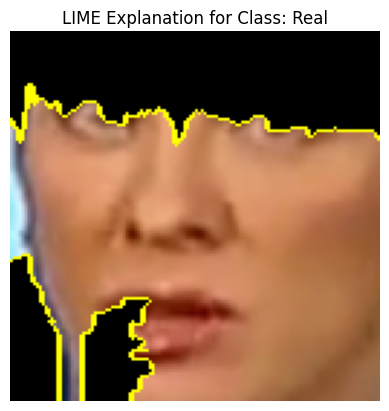

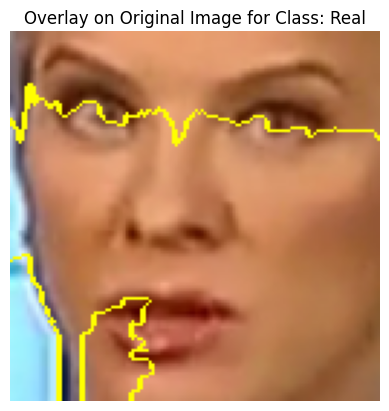

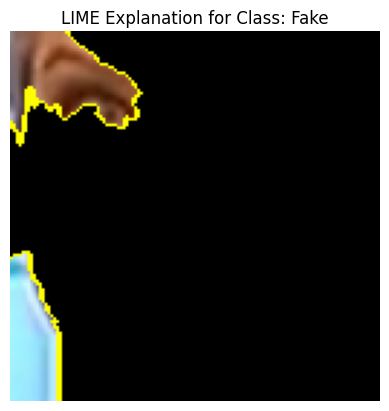

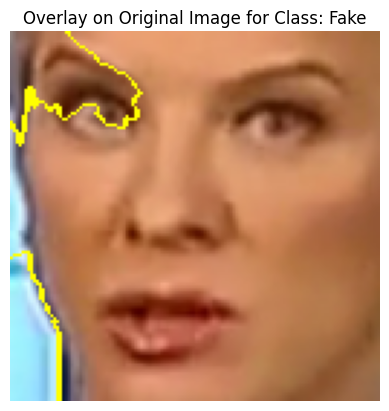

In [41]:
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from lime import lime_image


explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(X_test[0], model.predict, top_labels=2, hide_color=0, num_samples=1000)

for i in range(len(explanation.top_labels)):
    label = explanation.top_labels[i]
    temp, mask = explanation.get_image_and_mask(label, positive_only=True, num_features=5, hide_rest=True)
    plt.imshow(mark_boundaries(temp, mask))
    if label == 0:
        name = 'Real'
    else:
        name = 'Fake'
    plt.title(f"LIME Explanation for Class: {name}")
    plt.axis('off')
    plt.show()

    temp, mask = explanation.get_image_and_mask(label, positive_only=True, num_features=5, hide_rest=False)
    plt.imshow(mark_boundaries(temp, mask))
    plt.title(f"Overlay on Original Image for Class: {name}")
    plt.axis('off')
    plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 882ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 882ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 872ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/ste

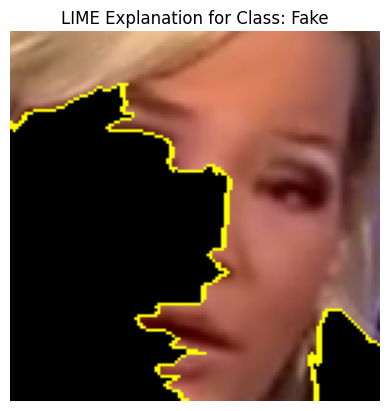

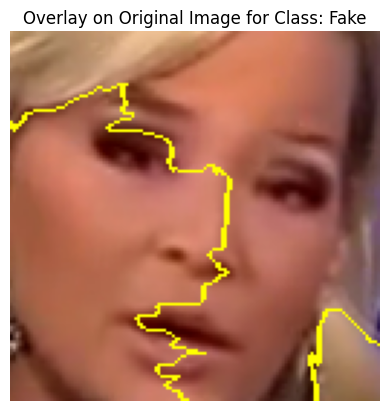

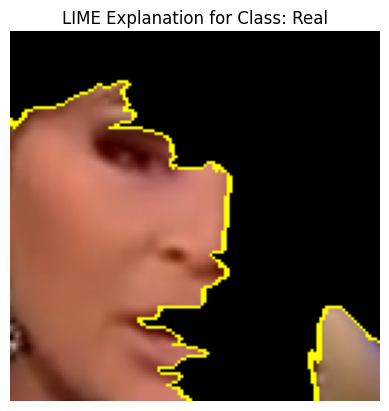

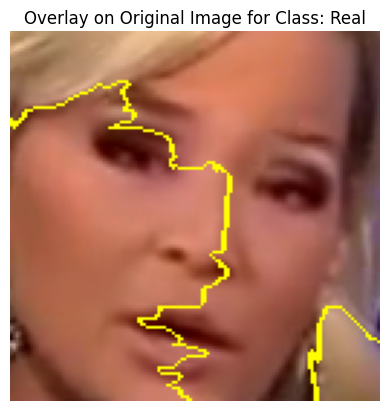

In [16]:
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from lime import lime_image


explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(X_test[-1], model.predict, top_labels=2, hide_color=0, num_samples=1000)

for i in range(len(explanation.top_labels)):
    label = explanation.top_labels[i]
    temp, mask = explanation.get_image_and_mask(label, positive_only=True, num_features=5, hide_rest=True)
    plt.imshow(mark_boundaries(temp, mask))
    if label == 0:
        name = 'Real'
    else:
        name = 'Fake'
    plt.title(f"LIME Explanation for Class: {name}")
    plt.axis('off')
    plt.show()

    temp, mask = explanation.get_image_and_mask(label, positive_only=True, num_features=5, hide_rest=False)
    plt.imshow(mark_boundaries(temp, mask))
    plt.title(f"Overlay on Original Image for Class: {name}")
    plt.axis('off')
    plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━

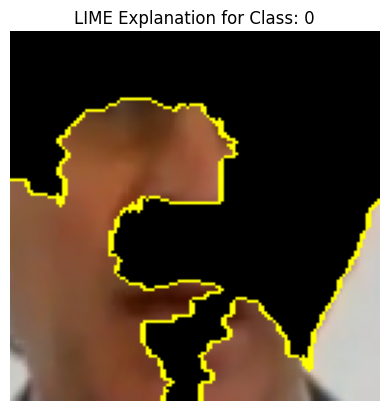

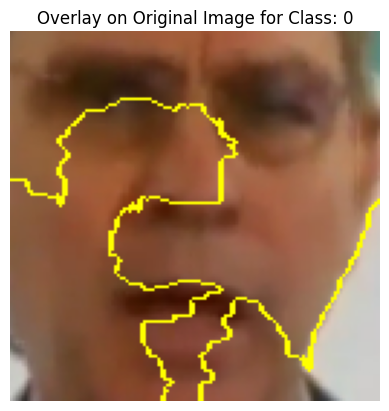

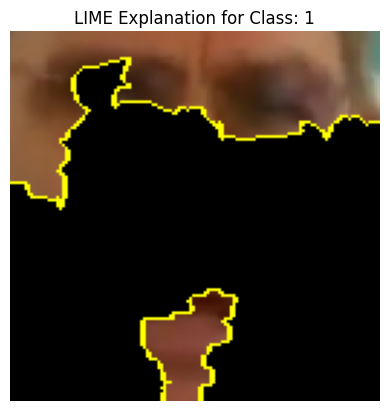

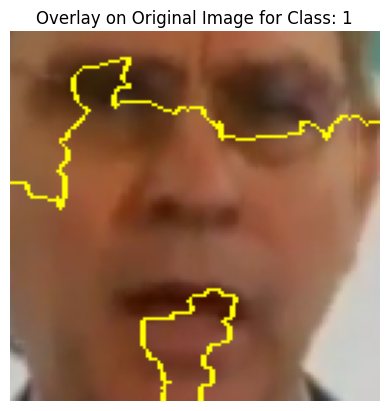

In [103]:
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from lime import lime_image


explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(X_test[0], model.predict, top_labels=2, hide_color=0, num_samples=1000)

for i in range(len(explanation.top_labels)):
    label = explanation.top_labels[i]
    temp, mask = explanation.get_image_and_mask(label, positive_only=True, num_features=5, hide_rest=True)
    plt.imshow(mark_boundaries(temp, mask))
    plt.title(f"LIME Explanation for Class: {label}")
    plt.axis('off')
    plt.show()

    temp, mask = explanation.get_image_and_mask(label, positive_only=True, num_features=5, hide_rest=False)
    plt.imshow(mark_boundaries(temp, mask))
    plt.title(f"Overlay on Original Image for Class: {label}")
    plt.axis('off')
    plt.show()

In [32]:
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()

def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear


score = CategoricalScore([0, 1])

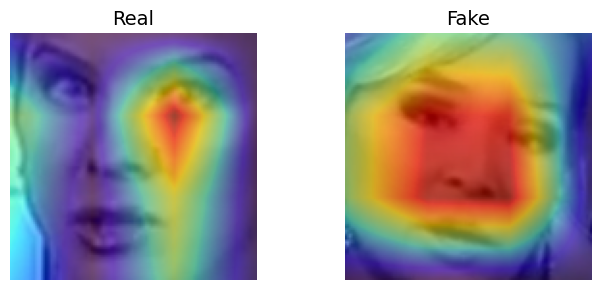

In [34]:
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam


X = np.array([X_test[0], X_test[-1]])
gradcam = Gradcam(model,
                  model_modifier=replace2linear,
                  clone=True)

cam = gradcam(score,
              X,
              penultimate_layer=-1)


binary_labels = ["Real", "Fake"]

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
for i, title in enumerate(binary_labels):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(X[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [20]:
X_test[-1:].shape

(1, 128, 128, 3)

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:50, 50.52s/it]               


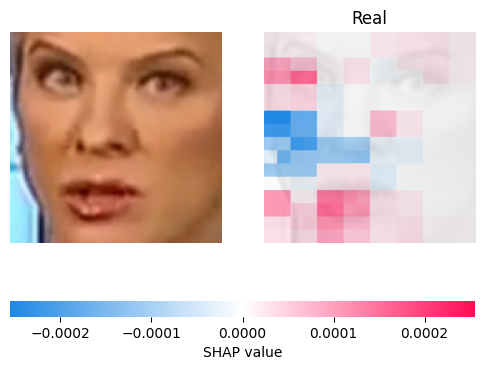

In [44]:
import shap


def f(input):
    tmp = input.copy()
    return model(tmp)


masker = shap.maskers.Image("inpaint_telea", X_test[0].shape)

explainer = shap.Explainer(f, masker)

shap_values = explainer(X_test[0:1], max_evals=500, batch_size=50, outputs=[0])


shap.image_plot(shap_values, X_test[0:1], labels=['Real'])